# Subsetting GEDI L4a Footprints

This tutorial will demonstrate how to subset [Global Ecosystem Dynamics Investigation (GEDI) L4a Footprint Level Aboveground Biomass Density (AGBD)](https://doi.org/10.3334/ORNLDAAC/1907) dataset to a study area of interest. GEDI L4a Version 1 dataset is currently available for the period of 2019-04-18 to 2020-09-02 and covers latitudes of 52 North to 52 South. GEDI L4a data files are natively in HDF5 format, and each file represents one International Space Station (ISS) orbit. 

The [previous tutorial](1_gedi_l4a_search_download.ipynb) explains how to download GEDI L4a files for a study area of interest (bounding box or polygon) and a specific period. Once all the GEDI L4a files are downloaded, the global orbits of GEDI L4a can be clipped or subsetted to the study area of interest.

## 1. Polygonal Area of Interest

We will use the boundary of the [Great Smokey Mountain National Park (GRSM)](https://www.nps.gov/grsm/planyourvisit/maps.htm) to demonstrate the spatial subsetting process. The boundary file is in ESRI Shapefile format in the folder called `grsm` in the repository. Let's read the boundary file and print out its coordinate system.

In [2]:
import geopandas as gpd
grsm_poly = gpd.read_file('grsm/GRSM_BOUNDARY_POLYGON_fid17.shp')
grsm_poly.crs

<Projected CRS: EPSG:26917>
Name: NAD83 / UTM zone 17N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 84°W and 78°W - onshore and offshore. Canada - Nunavut; Ontario; Quebec. United States (USA) - Florida; Georgia; Kentucky; Maryland; Michigan; New York; North Carolina; Ohio; Pennsylvania; South Carolina; Tennessee; Virginia; West Virginia.
- bounds: (-84.0, 23.81, -78.0, 84.0)
Coordinate Operation:
- name: UTM zone 17N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

As we see above, the boundary file is in the UTM 17N projection. Now let's plot our study area over a base map. First, we will convert to GRSM polygon into [Web Mercator (EPSG 3857)](https://epsg.io/3857) to bring it to the same coordinate reference system as the base map.

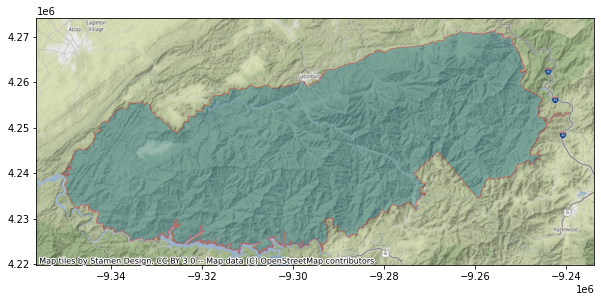

In [3]:
import contextily as ctx
grsm_epsg3857 = grsm_poly.to_crs(epsg=3857)
ax=grsm_epsg3857.plot(figsize=(10, 5), alpha=0.3, edgecolor='red')
ctx.add_basemap(ax)

## 2. Searching and Downloading GEDI L4a Files
We will search for all the GEDI L4A files with the orbits passing over the GRSM boundary using the NASA Earthdata Common Metadata Repository (CMR) API. Please refer to the [previous tutorial](1_gedi_l4a_search_download.ipynb) for more details.

In [4]:
import requests
from shapely.geometry import MultiPolygon, Polygon
from shapely.ops import orient
import pandas as pd

# converting to WGS84 coordinate system
grsm_epsg4326 = grsm_poly.to_crs(epsg=4326)

# orienting coordinates clockwise
grsm_epsg4326.geometry = grsm_epsg4326.geometry.apply(orient, args=(1,))

# reducing number of vertices in the polygon
# CMR has 1000000 bytes limit
grsm_epsg4326 = grsm_epsg4326.simplify(0.0005)

# We will use L2A to get bounding geometries for L4A
doi = '10.5067/GEDI/GEDI02_A.002'# GEDI L2A DOI 

# CMR API base url
cmrurl='https://cmr.earthdata.nasa.gov/search/' 

doisearch = cmrurl + 'collections.json?doi=' + doi
concept_id = requests.get(doisearch).json()['feed']['entry'][0]['id']

geojson = {"shapefile": ("grsm.json", grsm_epsg4326.geometry.to_json(), "application/geo+json")}

page_num = 1
page_size = 2000 # CMR page size limit

granule_arr = []

while True:
    
     # defining parameters
    cmr_param = {
        "collection_concept_id": concept_id, 
        "page_size": page_size,
        "page_num": page_num,
        "simplify-shapefile": 'true' # this is needed to bypass 5000 coordinates limit of CMR
    }
    
    granulesearch = cmrurl + 'granules.json'
    response = requests.post(granulesearch, data=cmr_param, files=geojson)
    granules = response.json()['feed']['entry']
    
    if granules:
        for g in granules:
            granule_url = ''
            granule_poly = ''
            
            # read file size
            granule_size = float(g['granule_size'])
            
            # reading bounding geometries
            if 'polygons' in g:
                polygons= g['polygons'][0]
                multipolygons = []
                for poly in polygons:
                    i=iter(poly.split (" "))
                    ltln = list(map(" ".join,zip(i,i)))
                    multipolygons.append(Polygon([[float(p.split(" ")[1]), float(p.split(" ")[0])] for p in ltln]))
                granule_poly = MultiPolygon(multipolygons)
            
            # Get URL of HDF5 files
            h5name = g['producer_granule_id'].split('_')
            ornlurl = 'https://daac.ornl.gov/daacdata/gedi/GEDI_L4A_AGB_Density/data/'
            granule_url = ornlurl + 'GEDI04_A_' + h5name[2] + '_' + h5name[3]  + '_' + h5name[5] + '_02_001_01.h5'
            granule_arr.append([granule_url, granule_poly])
               
        page_num += 1
    else: 
        break

# adding bound as the last row into the dataframe
# we will use this later in the plot
granule_arr.append(['GRSM', grsm_epsg4326.geometry.item() ]) 

# creating a pandas dataframe
l4adf = pd.DataFrame(granule_arr, columns=["granule_url", "granule_poly"])

Let's plot the bounding geometries of these files.

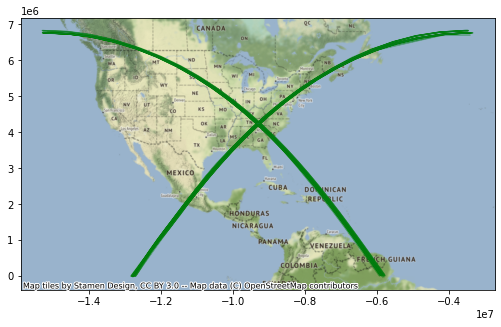

In [5]:
gdf = gpd.GeoDataFrame(l4adf, geometry=l4adf.granule_poly)
gdf.crs = "EPSG:4326"
gdf_epsg3857 = gdf.to_crs(epsg=3857)
ax=gdf_epsg3857.plot(figsize=(10, 5), alpha=0.3, edgecolor='green')
ctx.add_basemap(ax)

Each GEDI L4A file extends full ISS orbit going beyond the study area of interest. Now, let's plot a zoomed-in version of the above map over GRSM.

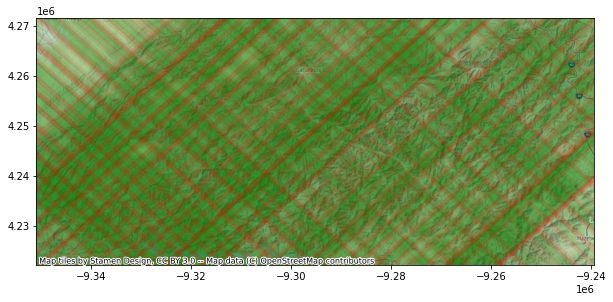

In [6]:
ax2=gdf_epsg3857[:-1].plot(figsize=(10, 5), alpha=0.1, color='green', edgecolor='red', linewidth=5)
minx, miny, maxx, maxy = grsm_epsg3857.total_bounds
ax2.set_xlim(minx, maxx)
ax2.set_ylim(miny, maxy)
ctx.add_basemap(ax2)

As we see in the figures above, GEDI has a good coverage over the GRSM area. 

## 3. Downloading the GEDI L4A files

We will now save the granule URLS into a file `granules.txt` and use `wget` command in the terminal to download all the 86 files. Please refer to the [previous tutorial](1_gedi_l4a_search_download.ipynb) for more details on downloading programmatically.

In [7]:
# drop duplicate URLs if any
l4a_granules = l4adf[:-1].drop_duplicates(subset=['granule_url'])
l4a_granules.to_csv('granules.txt', columns = ['granule_url'], index=False, header = False)

```wget --load-cookies ~/.urs_cookies --save-cookies ~/.urs_cookies --auth-no-challenge=on --keep-session-cookies --content-disposition -i granules.txt```

## 4. Subsetting the GEDI L4A files

Once all the GEDI L4A files are downloaded, we can clip the full orbit files to retrieve the footprints that fall within the area of interest, i.e. GRSM boundary. We have downloaded all the files to a folder called `full_orbit` for this tutorial.

### 4a. Exploring the data structure
Let's first open one of the L4A file `GEDI04_A_2019133103100_O02354_T00724_02_001_01.h5` we just downloaded and print the root-level variable group.

In [8]:
import h5py
import numpy as np
hf = h5py.File('full_orbit/GEDI04_A_2019133103100_O02354_T00724_02_001_01.h5', 'r')
hf.keys()

<KeysViewHDF5 ['ANCILLARY', 'BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011', 'METADATA']>

All science variables are organized by eight beams of the GEDI. Please refer to the [GEDI L4A user guide](https://daac.ornl.gov/GEDI/guides/GEDI_L4A_AGB_Density.html) and [GEDI L4A data dictionary](https://daac.ornl.gov/daacdata/gedi/GEDI_L4A_AGB_Density/comp/GEDI_L4A_Product_Data_Dictionary.pdf) for details on file organization. Let's look into one of the beam group `BEAM0110` and print all the science dataset (SDS) variables within the group. 

In [9]:
beam0110 = hf.get('BEAM0110')
beam0110.keys()

<KeysViewHDF5 ['agbd', 'agbd_pi_lower', 'agbd_pi_upper', 'agbd_prediction', 'agbd_se', 'agbd_t', 'agbd_t_se', 'algorithm_run_flag', 'beam', 'channel', 'degrade_flag', 'delta_time', 'elev_lowestmode', 'geolocation', 'l2_quality_flag', 'l4_quality_flag', 'land_cover_data', 'lat_lowestmode', 'lon_lowestmode', 'master_frac', 'master_int', 'predict_stratum', 'predictor_limit_flag', 'response_limit_flag', 'selected_algorithm', 'selected_mode', 'selected_mode_flag', 'sensitivity', 'shot_number', 'solar_elevation', 'surface_flag', 'xvar']>

In the above list of variables, 2 science dataset (SDS)  are particulary useful for spatial subsetting: `lat_lowestmode` and `lon_lowestmode`, which represent ground location of each GEDI shot.

Let's plot all the beams in the map. 

In [10]:
lat_l = []
lon_l = []
beam_n = []
for var in list(hf.keys()):
    if var.startswith('BEAM'):
        beam = hf.get(var)
        lat = beam.get('lat_lowestmode')[:]
        lon = beam.get('lon_lowestmode')[:]
        lat_l.extend(lat.tolist()) # latitude
        lon_l.extend(lon.tolist()) # longitude
        n = lat.shape[0] # number of shots in the beam group
        beam_n.extend(np.repeat(str(var), n).tolist())
geo_arr = list(zip(beam_n,lat_l,lon_l))
l4adf = pd.DataFrame(geo_arr, columns=["beam", "lat_lowestmode", "lon_lowestmode"])
l4adf

,beam,lat_lowestmode,lon_lowestmode
0,BEAM0000,-42.301381,97.489607
1,BEAM0000,-42.301235,97.489892
2,BEAM0000,-42.301089,97.490176
3,BEAM0000,-42.300943,97.490460
4,BEAM0000,-42.300797,97.490745
...,...,...,...
3456638,BEAM1011,-18.900116,-38.297046
3456639,BEAM1011,-18.900522,-38.296710
3456640,BEAM1011,-18.900928,-38.296375
3456641,BEAM1011,-18.901334,-38.296039


The pandas dataframe `l4adf` contains beam names, latitude and longitude columns. This particular GEDI orbit recorded a total of 3,456,643 shots. Now we can convert `l4adf` to a geopandas dataframe `l4agdf` and clip the file by the boundary of the GRSM.

In [11]:
l4agdf = gpd.GeoDataFrame(l4adf, geometry=gpd.points_from_xy(l4adf.lon_lowestmode, l4adf.lat_lowestmode))
l4agdf.crs = "EPSG:4326"
l4agdf_gsrm = l4agdf[l4agdf['geometry'].within(grsm_epsg4326.geometry[0])]    
l4agdf_gsrm

,beam,lat_lowestmode,lon_lowestmode,geometry
219951,BEAM0000,35.695502,-83.583337,POINT (-83.58334 35.69550)
219952,BEAM0000,35.695154,-83.582862,POINT (-83.58286 35.69515)
219953,BEAM0000,35.694823,-83.582440,POINT (-83.58244 35.69482)
219954,BEAM0000,35.694474,-83.581964,POINT (-83.58196 35.69447)
219955,BEAM0000,35.694136,-83.581519,POINT (-83.58152 35.69414)
...,...,...,...,...
3323244,BEAM1011,35.490137,-83.381701,POINT (-83.38170 35.49014)
3323245,BEAM1011,35.489793,-83.381241,POINT (-83.38124 35.48979)
3323246,BEAM1011,35.489451,-83.380785,POINT (-83.38078 35.48945)
3323247,BEAM1011,35.489113,-83.380333,POINT (-83.38033 35.48911)


The geopandas dataframe `l4agdf_gsrm` contains the shots (4,506 shots in total) that fall within the GSRM boundary. Now, let's plot these into a map.

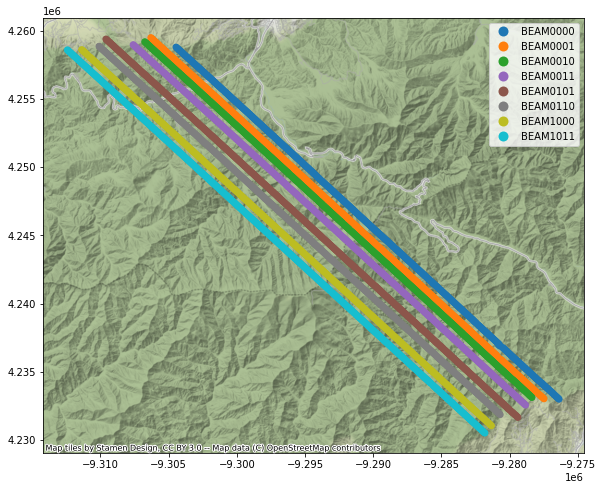

In [12]:
l4agdf_gsrm_epsg3857 = l4agdf_gsrm.to_crs(epsg=3857)
ax2=l4agdf_gsrm_epsg3857.plot(column='beam', legend=True, figsize=(10, 8))
ctx.add_basemap(ax2)

The above map shows the swath coverage of GEDI - a typical swath is ~4200m wide. GEDI instrument produces eight ground tracks plotted in the map with different colors. Let's zoom in into an area and look at the locations of actual shots.

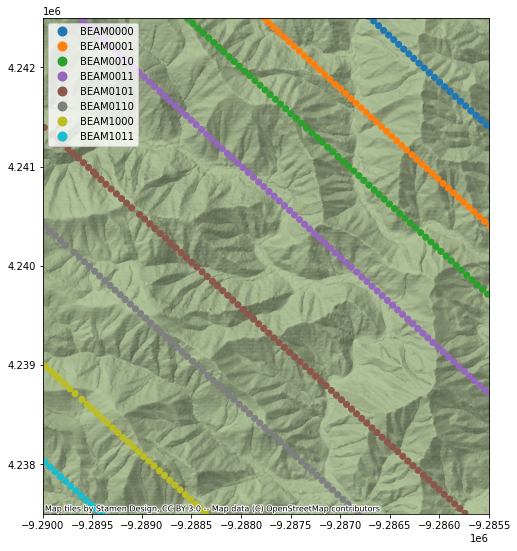

In [13]:
minx1, miny1, maxx1, maxy1 = [-9290000, 4237500, -9285500, 4242500]
ax3=l4agdf_gsrm_epsg3857.plot(column='beam', legend=True, figsize=(8, 10))
ax3.set_xlim(minx1, maxx1)
ax3.set_ylim(miny1, maxy1)
ctx.add_basemap(ax3)

# close the opened hdf5 file
hf.close()

The GEDI shots (or footprints) are separated by ~60 m along the track and ~600 m across the track. For more detailed look on GEDI L4A data, refer to [this tutorial on exploring GEDI L4A](3_gedi_l4a_exploring_data.ipynb).

### 4b. Subsetting all downloaded files

In the Steps 2 and 3 above, we downloaded L4A files into the directory `full_orbit`. We will now loop over each of these files and create a clipped version of the files into a new directory `subset`. 

In [14]:
from glob import glob
from os import path

indir = 'full_orbit'
outdir = 'subset'

# reading boundary file       
grsm_poly = gpd.read_file('grsm/GRSM_BOUNDARY_POLYGON_fid17.shp')
# converting to WGS84 coordinate system
grsm_epsg4326 = grsm_poly.to_crs(epsg=4326)

for infile in glob(path.join(indir, '*.h5')):
    outfile = path.join(outdir, path.basename(infile))
    hf_in = h5py.File(infile, 'r')
    hf_out = h5py.File(outfile, 'w')
    
    # copy ANCILLARY and METADATA groups
    var1 = ["/ANCILLARY", "/METADATA"]
    for v in var1:
        hf_in.copy(hf_in[v],hf_out)
    
    # loop through BEAMXXXX groups
    for v in list(hf_in.keys()):
        if v.startswith('BEAM'):
            beam = hf_in[v]
            # find the shots that overlays the area of interest (GRSM)
            lat = beam['lat_lowestmode'][:]
            lon = beam['lon_lowestmode'][:]
            i = np.arange(0, len(lat), 1) # index
            geo_arr = list(zip(lat,lon, i))
            l4adf = pd.DataFrame(geo_arr, columns=["lat_lowestmode", "lon_lowestmode", "i"])
            l4agdf = gpd.GeoDataFrame(l4adf, geometry=gpd.points_from_xy(l4adf.lon_lowestmode, l4adf.lat_lowestmode))
            l4agdf.crs = "EPSG:4326"
            l4agdf_gsrm = l4agdf[l4agdf['geometry'].within(grsm_epsg4326.geometry[0])]  
            indices = l4agdf_gsrm.i

            # copy BEAMS to the output file
            for key, value in beam.items():
                if isinstance(value, h5py.Group):
                    for key2, value2 in value.items():
                        group_path = value2.parent.name
                        group_id = hf_out.require_group(group_path)
                        dataset_path = group_path + '/' + key2
                        hf_out.create_dataset(dataset_path, data=value2[:][indices])
                        for attr in value2.attrs.keys():
                            hf_out[dataset_path].attrs[attr] = value2.attrs[attr]
                else:
                    group_path = value.parent.name
                    group_id = hf_out.require_group(group_path)
                    dataset_path = group_path + '/' + key
                    hf_out.create_dataset(dataset_path, data=value[:][indices])
                    for attr in value.attrs.keys():
                        hf_out[dataset_path].attrs[attr] = value.attrs[attr]

    hf_in.close()
    hf_out.close()


Now, new the subset files are created in the `subset` directory. We will use the subset files to create a map of above ground biomass density (the variable `agbd` inside `BEAMXXXX` groups) of the GRSM. 

In [16]:
lat_l = []
lon_l = []
agbd = []
outdir = 'subset'
for subfile in glob(path.join(outdir, '*.h5')):
    hf_in = h5py.File(subfile, 'r')
    for v in list(hf_in.keys()):
        if v.startswith('BEAM'):
            beam = hf_in[v]
            lat_l.extend(beam['lat_lowestmode'][:].tolist()) 
            lon_l.extend(beam['lon_lowestmode'][:].tolist()) 
            agbd.extend(beam['agbd'][:].tolist()) 
    hf_in.close()
geo_arr = list(zip(agbd,lat_l,lon_l))
df = pd.DataFrame(geo_arr, columns=["agbd", "lat_lowestmode", "lon_lowestmode"])
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon_lowestmode, df.lat_lowestmode))
gdf

,agbd,lat_lowestmode,lon_lowestmode,geometry
0,-9999.0,35.784732,-83.197382,POINT (-83.19738 35.78473)
1,-9999.0,35.784386,-83.196918,POINT (-83.19692 35.78439)
2,-9999.0,35.784041,-83.196435,POINT (-83.19643 35.78404)
3,-9999.0,35.783695,-83.195968,POINT (-83.19597 35.78370)
4,-9999.0,35.783349,-83.195501,POINT (-83.19550 35.78335)
...,...,...,...,...
284014,-9999.0,35.448155,-83.705689,POINT (-83.70569 35.44815)
284015,-9999.0,35.447807,-83.705226,POINT (-83.70523 35.44781)
284016,-9999.0,35.447460,-83.704763,POINT (-83.70476 35.44746)
284017,-9999.0,35.447113,-83.704300,POINT (-83.70430 35.44711)


In the above table, we see there are some shots with fill value (-9999). We will exclude these shots in the map below.

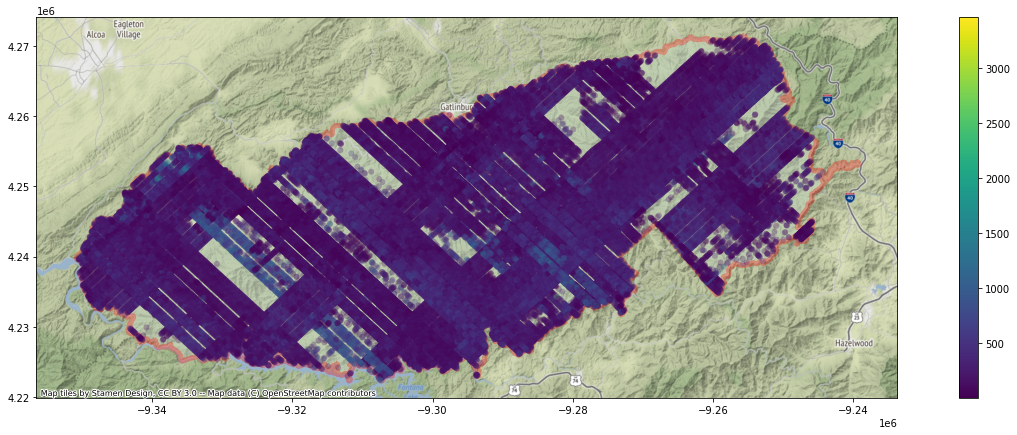

In [17]:
grsm_df = pd.DataFrame([[-9999,-9999,-9999,grsm_epsg4326.geometry.item()]], columns=['agbd','lat_lowestmode','lon_lowestmode', 'geometry'])
gdf = pd.concat([gdf, grsm_df])
gdf.crs="EPSG:4326"
gdf_epsg3857 = gdf.to_crs(epsg=3857)
ax4=gdf_epsg3857[-1:].plot(color='white', edgecolor='red', alpha=0.3, linewidth=5, figsize=(22, 7))
gdf_epsg3857[gdf_epsg3857['agbd'] != -9999][:-1].plot(ax=ax4, column='agbd', alpha=0.3, linewidth=0, legend=True)
ctx.add_basemap(ax4)

### 4c. Saving the subsets to different formats
In the step above, we created a HDF5 formatted output, which is the native format of GEDI L4A datasets. The HDF5 files can be output to `geojson` or `csv` or `ESRI Shapefile` using the geopandas.

In [18]:
from glob import glob
from os import path
import pandas as pd
import h5py

outdir = 'subset'
subset_df = pd.DataFrame()
for subfile in glob(path.join(outdir, '*.h5')):
    hf_in = h5py.File(subfile, 'r')
    for v in list(hf_in.keys()):
        if v.startswith('BEAM'):
            col_names = []
            col_val = []
            beam = hf_in[v]
            # copy BEAMS 
            for key, value in beam.items():
                # looping through subgroups
                if isinstance(value, h5py.Group):
                    for key2, value2 in value.items():
                        if (key2 != "shot_number"):
                             # xvar variables have 2D
                            if (key2.startswith('xvar')):
                                for r in range(4):
                                    col_names.append(key2 + '_' + str(r+1))
                                    col_val.append(value2[:, r].tolist())
                            else:
                                col_names.append(key2)
                                col_val.append(value2[:].tolist())
                
                #looping through base group
                else:
                    # xvar variables have 2D
                    if (key.startswith('xvar')):
                        for r in range(4):
                            col_names.append(key + '_' + str(r+1))
                            col_val.append(value[:, r].tolist())
                    else:
                        col_names.append(key)
                        col_val.append(value[:].tolist())
            
            # create a pandas dataframe        
            beam_df = pd.DataFrame(map(list, zip(*col_val)), columns=col_names) 
            # Inserting BEAM names
            beam_df.insert(0, 'BEAM', np.repeat(str(v), len(beam_df.index)).tolist())
            # Appending to the subset_df dataframe
            subset_df = subset_df.append(beam_df)
    hf_in.close()

Now, all the variables are stored in a pandas dataframe `subset_df`. We can print the dataframe.

In [19]:
# Setting 'shot_number' as dataframe index. shot_number column is unique
subset_df = subset_df.set_index('shot_number') 
subset_df

,BEAM,agbd,agbd_pi_lower,agbd_pi_upper,agbd_a1,agbd_a10,agbd_a2,agbd_a3,agbd_a4,agbd_a5,...,selected_algorithm,selected_mode,selected_mode_flag,sensitivity,solar_elevation,surface_flag,xvar_1,xvar_2,xvar_3,xvar_4
shot_number,,,,,,,,,,,,,,,,,,,,,
36520007300221728,BEAM0000,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,1,0,0,0.761383,-18.489359,1,-9999.0,-9999.0,-9999.0,-9999.0
36520007500221729,BEAM0000,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,1,0,0,3.842509,-18.489891,1,-9999.0,-9999.0,-9999.0,-9999.0
36520007700221730,BEAM0000,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,1,0,0,-0.076495,-18.490433,1,-9999.0,-9999.0,-9999.0,-9999.0
36520007900221731,BEAM0000,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,1,0,0,-6.376299,-18.490967,1,-9999.0,-9999.0,-9999.0,-9999.0
36520008100221732,BEAM0000,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,1,0,0,-10.702982,-18.491501,1,-9999.0,-9999.0,-9999.0,-9999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64141122000413736,BEAM1011,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,1,0,0,0.735808,-58.018318,0,-9999.0,-9999.0,-9999.0,-9999.0
64141122200413737,BEAM1011,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,1,0,0,295.585724,-58.018833,0,-9999.0,-9999.0,-9999.0,-9999.0
64141122400413738,BEAM1011,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,1,0,0,2.344156,-58.019348,0,-9999.0,-9999.0,-9999.0,-9999.0


The dataframe has 205 columns representing GEDI L4A variables. We can export it to a **CSV** file directly as:

In [20]:
subset_df.to_csv('subset/grsm_subset.csv') # Export to CSV

If we want to save the file as one of the geospatial formats (such as **GEOJSON**, **KML** or **ESRI Shapefile**), we need to first convert the dataframe into a geopandas dataframe, and export to various formats.

In [ ]:
subset_gdf = gpd.GeoDataFrame(subset_df, geometry=gpd.points_from_xy(subset_df.lon_lowestmode, subset_df.lat_lowestmode))
subset_gdf.crs = "EPSG:4326"

# convert object types columns to strings. object types are not supported
for c in subset_gdf.columns:
    if subset_gdf[c].dtype == 'object':
        subset_gdf[c] = subset_gdf[c].astype(str)

# Export to GeoJSON
subset_gdf.to_file('subset/grsm_subset.geojson', driver='GeoJSON')
# Export to ESRI Shapefile
subset_gdf.to_file('subset/grsm_subset.shp')